# 02-03 : Threshold Optimisation

In [1]:
import pandas as pd
import numpy as np
from typing import List

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, jaccard_score, accuracy_score, f1_score

In [2]:
data_path = '../../data'
input_path = f'{data_path}/output/02_zero_shot'

true_labels_path = f'{input_path}/02-01_bart-large-mnli_test_true.npy'
predicted_labels_path = f'{input_path}/02-01_bart-large-mnli_test.npy'

## 1. Load Data

In [3]:
y_true = np.load(true_labels_path).tolist()
y_pred = np.load(predicted_labels_path).tolist()

## 2. Evaluation Metrics

In [4]:
def calculate_metric(metric_func, y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float, **kwargs):
    # Convert predictions to binary
    y_pred = [[int(prob > threshold) for prob in pred] for pred in y_pred_proba]

    # return the subset accuracy
    return metric_func(y_true, y_pred, **kwargs)

def f1_score_macro(y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float=0.5):
    """Calculate F1 Score (Macro)."""
    return calculate_metric(f1_score, y_true, y_pred_proba, threshold, average='macro')

def f1_score_weighted(y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float=0.5):
    """Calculate F1-score (Weighted-Average)."""
    return calculate_metric(f1_score, y_true, y_pred_proba, threshold, average='weighted')

def jaccard_similarity(y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float=0.5):
    """Calculate average Jaccard Similarity."""
    return calculate_metric(jaccard_score, y_true, y_pred_proba, threshold, average='samples')

def subset_accuracy(y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float=0.5):
    """Calculate Subset Accuracy (Exact Match Accuracy)."""
    return calculate_metric(accuracy_score, y_true, y_pred_proba, threshold)


# test the functions
threshold = 0.5
print(f"F1 Score (Macro-Average)   \t{f1_score_macro(y_true, y_pred, threshold):.3f}")
print(f"F1 Score (Weighted-Average)\t{f1_score_weighted(y_true, y_pred, threshold):.3f}")
print(f"Average Jaccard Similarity \t{jaccard_similarity(y_true, y_pred, threshold):.3f}")
print(f"Subset Accuracy            \t{subset_accuracy(y_true, y_pred, threshold):.3f}")

F1 Score (Macro-Average)   	0.355
F1 Score (Weighted-Average)	0.466
Average Jaccard Similarity 	0.301
Subset Accuracy            	0.074


In [5]:
def evaluate_all(y_true,
                 y_pred_proba,
                 threshold:float=0.5):

    """Evaluate all metrics and display a summary."""
    f1_macro_score = f1_score_macro(y_true, y_pred_proba, threshold)
    f1_weighted_score = f1_score_weighted(y_true, y_pred_proba,threshold)
    jaccard_similarity_score = jaccard_similarity(y_true, y_pred_proba, threshold)
    subset_accuracy_score = subset_accuracy(y_true, y_pred_proba, threshold)

    # Display a summary of the evaluation
    print(f"F1 Score (Macro-Average)   \t{f1_macro_score:.3f}")
    print(f"F1 Score (Weighted-Average)\t{f1_weighted_score:.3f}")
    print(f"Average Jaccard Similarity \t{jaccard_similarity_score:.3f}")
    print(f"Subset Accuracy            \t{subset_accuracy_score:.3f}")

In [6]:
evaluate_all(y_true, y_pred)

F1 Score (Macro-Average)   	0.355
F1 Score (Weighted-Average)	0.466
Average Jaccard Similarity 	0.301
Subset Accuracy            	0.074


## 3. Optimize Threshold

In [7]:
def optimize_score(metric_func, y_true:List[List[int]], y_pred_proba:List[List[float]]):
    """Optimize the threshold for a given metric."""
    scores = []
    
    # get the scores for different thresholds
    for threshold in tqdm(np.arange(0.0, 1.0, 0.01)):
        score = metric_func(y_true, y_pred, threshold)
        scores.append({
            'threshold': threshold,
            'score': score
        })
        
    # convert to DataFrame
    df_scores = pd.DataFrame(scores)
    
    # find the threshold with the highest F1 score
    best_threshold = df_scores.loc[df_scores['score'].idxmax()]['threshold']
    best_score = df_scores['score'].max()
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Best Score: {best_score:.3f}")
    
    # plot the F1 scores
    plt.plot(df_scores['threshold'], df_scores['score'])
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{metric_func.__name__} vs. Threshold')
    plt.show()

### 3.1. F1 Score (Macro-Average)

  0%|          | 0/100 [00:00<?, ?it/s]

Best Threshold: 0.76
Best Score: 0.387


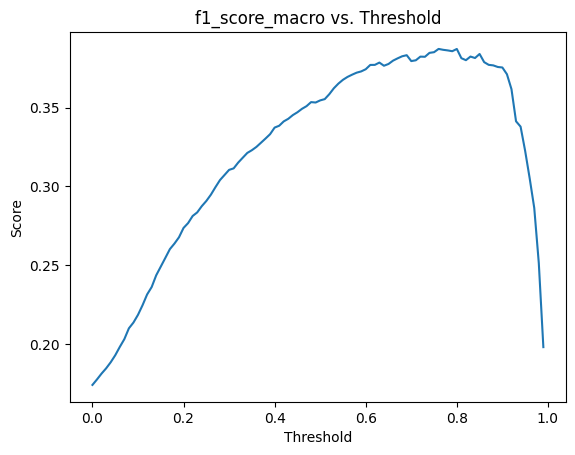

In [8]:
optimize_score(f1_score_macro, y_true, y_pred)

### 3.2. F1 Score (Weighted-Average)

  0%|          | 0/100 [00:00<?, ?it/s]

Best Threshold: 0.76
Best Score: 0.503


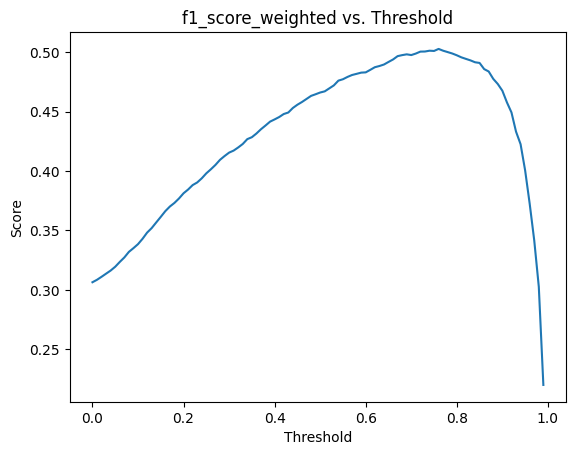

In [9]:
optimize_score(f1_score_weighted, y_true, y_pred)

### 3.3. Average Jaccard Similarity

  0%|          | 0/100 [00:00<?, ?it/s]

Best Threshold: 0.76
Best Score: 0.358


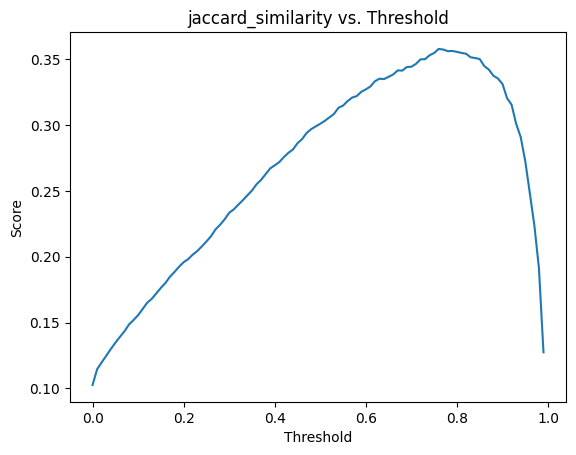

In [10]:
optimize_score(jaccard_similarity, y_true, y_pred)

### 3.4 Subset Accuracy 

  0%|          | 0/100 [00:00<?, ?it/s]

Best Threshold: 0.90
Best Score: 0.205


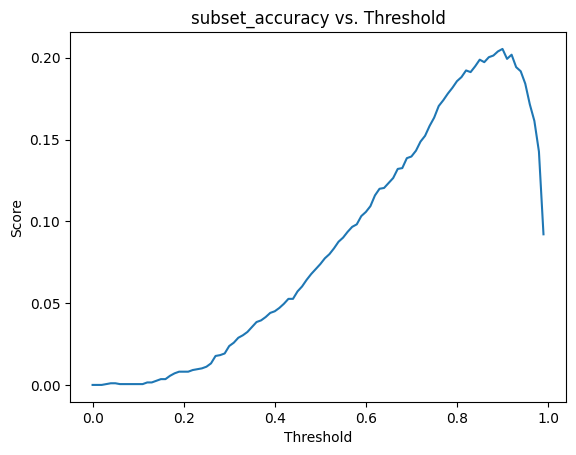

In [11]:
optimize_score(subset_accuracy, y_true, y_pred)

### 3.5 Optimized Threshold

In [12]:
evaluate_all(y_true, y_pred, threshold=0.9)

F1 Score (Macro-Average)   	0.376
F1 Score (Weighted-Average)	0.468
Average Jaccard Similarity 	0.331
Subset Accuracy            	0.205
